# Compile Catalogs

In [2]:
#from astroquery.gaia import Gaia
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.table import Table
import numpy as np
from astropy.io.ascii import read

## Import Catalogs

In [5]:
# Open the GCNS catalog
# https://arxiv.org/abs/2012.02061
# Parse using the ReadMe:
gcns = read('/datax/scratch/emmay/GCNS/table1c.dat', format='cds', readme='/datax/scratch/emmay/GCNS/ReadMe')
gcns.columns

<TableColumns names=('GaiaEDR3','RAdeg','e_RAdeg','DEdeg','e_DEdeg','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','Gmag','RFG','BPmag','RFBP','RPmag','RFRP','E(BP/RP)','RUWE','IPDfmp','RV','e_RV','r_RV','f_RV','GCNSprob','WDprob','Dist1','Dist16','Dist50','Dist84','xcoord50','xcoord16','xcoord84','ycoord50','ycoord16','ycoord84','zcoord50','zcoord16','zcoord84','Uvel50','Uvel16','Uvel84','Vvel50','Vvel16','Vvel84','Wvel50','Wvel16','Wvel84','GUNN','r_GUNN','gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','2MASS','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag','WISE','W1mag','e_W1mag','W2mag','e_W2mag','W3mag','e_W3mag','W4mag','e_W4mag')>

In [7]:
# Open the Gaia-ESO file
# https://doi.eso.org/10.18727/archive/25
hdulist = fits.open('/datax/scratch/emmay/GaiaESO/result_ervvfchjzcb7sbg9.fits')
catalog_hdu = hdulist[1]
GaiaESO = catalog_hdu.data

In [8]:
# Open the NEID file
# https://neid.ipac.caltech.edu/search_advanced.php
neid = Table.read('/datax/scratch/emmay/NEID/table_Level-2.csv')
# Clean mask on full NEID table
mask = (
    (neid['qra'] != None) & (neid['qdec'] != None) &
    (neid['qra'] != '') & (neid['qdec'] != '') &
    (neid['qra'] != 'None') & (neid['qdec'] != 'None')
)

# Apply mask ONCE to get clean NEID
neid_clean = neid[mask]
len(neid_clean)

14205

In [9]:
# Open the HIRES file
# https://koa.ipac.caltech.edu/cgi-bin/KOA/nph-KOAlogin
hires = Table.read('/datax/scratch/emmay/HIRES/hires.csv')
mask = np.isfinite(hires['ra']) & np.isfinite(hires['dec'])
mask &= (~hires['ra'].mask) & (~hires['dec'].mask)
mask &= hires['dec'] <=90
hires_clean = hires[mask]

In [10]:
max(hires['dec'])

90.03

In [11]:
# Open HARPS
with fits.open('/datax/scratch/emmay/HARPS/J_A+A_636_A74_list.dat.fits') as hdul:
    data = hdul[1].data

# Convert to Pandas for easy cleaning
df = pd.DataFrame(data.tolist(), columns=data.columns.names)

for col in ['RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs']:
    # Decode bytes -> string -> strip -> safe for numeric
    df[col] = df[col].apply(lambda x: x.decode('utf-8').strip())

# Now convert numeric parts to float
df['RAh'] = df['RAh'].astype(float)
df['RAm'] = df['RAm'].astype(float)
df['RAs'] = df['RAs'].astype(float)

df['DEd'] = df['DEd'].astype(float)
df['DEm'] = df['DEm'].astype(float)
df['DEs'] = df['DEs'].astype(float)

# DE- stays string
df['DE-'] = df['DE-'].astype(str).str.strip()

# Compute RA in decimal degrees
df['RA_deg'] = (df['RAh'] + df['RAm']/60 + df['RAs']/3600) * 15

# Compute Dec with sign
sign = np.where(df['DE-'] == '-', -1, 1)
df['Dec_deg'] = sign * (df['DEd'] + df['DEm']/60 + df['DEs']/3600)

harps = Table.from_pandas(df)


In [12]:
# Open APOGEE
hdulist = fits.open('/datax/scratch/emmay/APOGEE/allStarLite-dr17-synspec_rev1.fits')
catalog_hdu = hdulist[1]
apogee = catalog_hdu.data
mask = ~np.isnan(apogee['RA']) & ~np.isnan(apogee['DEC'])
apogee = apogee[mask]
type(apogee)

astropy.io.fits.fitsrec.FITS_rec

## Some Sanity Checks
Comparing with https://github.com/jradavenport/spectro100/blob/main/gathering%20data.ipynb

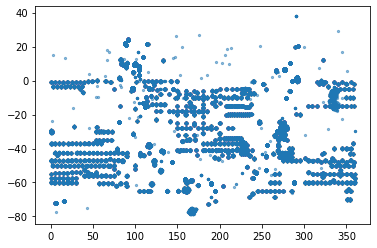

In [13]:
# Sanity check of RA vs DEC plot compared to Jim's
plt.figure()
plt.scatter(GaiaESO['RA'], GaiaESO['DECLINATION'], s=5, alpha=0.5)

In [14]:
GCNS_C = SkyCoord(ra=gcns['RAdeg'], dec=gcns['DEdeg'], frame='icrs')
GaiaESO_C = SkyCoord(ra=GaiaESO['RA']*u.degree, dec=GaiaESO['DECLINATION']*u.degree)


In [15]:
# Again, good sanity check - matches with what Jim got
Gdx = GCNS_C.match_to_catalog_sky(GaiaESO_C)
Gmtch = Gdx[0][Gdx[1].to('arcsec').value < 5]
print(sum(Gdx[1].to('arcsec').value < 5))

147


## Crossmatching with GCNS

In [16]:
# 1) Use match_to_catalog_sky 
idx, d2d, _ = GCNS_C.match_to_catalog_sky(GaiaESO_C)

# 2) Limit to matches within 2 arcsec
matches = d2d < 2 * u.arcsec

# 3) Prepare arrays
is_in_GaiaESO = np.zeros(len(gcns), dtype=int)
GaiaESO_name = np.full(len(gcns), np.nan, dtype=object)

# 4) Fill only for matched rows
is_in_GaiaESO[matches] = 1
GaiaESO_name[matches] = GaiaESO['OBJECT'][idx[matches]]

# 5) Store in new copy
catalog_summary = gcns["GaiaEDR3", "RAdeg", "DEdeg", "Dist50", "Gmag", "BPmag", "RPmag"].copy()
catalog_summary['is_in_GaiaESO'] = is_in_GaiaESO
catalog_summary['GaiaESO_name'] = GaiaESO_name
catalog_summary.rename_column('GaiaEDR3', 'GCNS_name')
catalog_summary.rename_column('RAdeg', 'GCNS_RA')
catalog_summary.rename_column('DEdeg', 'GCNS_DEC')


In [17]:
catalog_summary[catalog_summary['is_in_GaiaESO']==1]

GCNS_name,GCNS_RA,GCNS_DEC,Dist50,Gmag,BPmag,RPmag,is_in_GaiaESO,GaiaESO_name
,deg,deg,kpc,mag,mag,mag,,
int64,float64,float64,float64,float64,float64,float64,int64,object
2336728947968831104,1.8871494,-23.8183163,0.0328,8.4831,8.8938,7.8974,1,00073283-2349062
2445242288839432704,2.5260238,-3.3400922,0.04808,19.0171,21.7712,17.4335,1,00100625-0320247
4918806107423681920,4.6915643,-57.6499893,0.0808,18.5364,20.904,17.0725,1,00184592-5738599
2528577058247110784,7.5079263,-3.4888476,0.1149,19.8301,21.4244,18.1984,1,00300188-0329196
5001454888951528704,15.0923768,-36.9642585,0.07851,15.8738,17.5254,14.6402,1,01002215-3657513
2584834502690477312,16.5533881,13.2526955,0.05466,8.0189,8.3152,7.5048,1,01061278+1315096
2531223307857060096,17.7622438,-3.5432802,0.10205,17.6236,19.5043,16.3161,1,01110292-0332351
4983718632524887936,19.7219476,-42.460977,0.10563,18.8423,20.1053,17.4086,1,01185326-4227395


In [18]:
# === 1) Make SkyCoord for NEID, with clean data ===
neid_c = SkyCoord(np.array(neid_clean['qra']), np.array(neid_clean['qdec']), unit=(u.hourangle, u.deg))
nok = np.isfinite(neid_c.ra) & np.isfinite(neid_c.dec)
neid_c = neid_c[nok]

# === 2) Match GCNS to NEID ===
idx_neid, d2d_neid, _ = GCNS_C.match_to_catalog_sky(neid_c)

# === 3) Limit to matches within 2 arcsec (or your desired threshold) ===
matches_neid = d2d_neid < 2 * u.arcsec

# === 4) Prepare columns ===
is_in_NEID = np.zeros(len(gcns), dtype=int)
NEID_name = np.full(len(gcns), np.nan, dtype=object)  # or use '' instead of np.nan if you prefer strings

# === 5) Fill matched rows ===
is_in_NEID[matches_neid] = 1
NEID_name[matches_neid] = neid_clean['object'][nok][idx_neid[matches_neid]]

# === 6) Add to summary table ===
catalog_summary['is_in_NEID'] = is_in_NEID
catalog_summary['NEID_name'] = NEID_name

In [19]:
# === 2) Build SkyCoord in decimal degrees ===
hires_c = SkyCoord(hires_clean['ra']*u.deg, hires_clean['dec']*u.deg, frame='icrs')

# === 3) Match GCNS to HIRES ===
idx_hires, d2d_hires, _ = GCNS_C.match_to_catalog_sky(hires_c)

# === 4) Limit to matches within e.g. 2 arcsec ===
matches_hires = d2d_hires < 2 * u.arcsec

# === 5) Prepare columns ===
is_in_HIRES = np.zeros(len(gcns), dtype=int)
HIRES_name = np.full(len(gcns), np.nan, dtype=object)

# === 6) Fill matched rows ===
# Adjust the column name 'object' to whatever your HIRES ID column is!
is_in_HIRES[matches_hires] = 1
HIRES_name[matches_hires] = hires_clean['ofname'][idx_hires[matches_hires]]

# === 7) Add to catalog_summary ===
catalog_summary['is_in_HIRES'] = is_in_HIRES
catalog_summary['HIRES_name'] = HIRES_name

In [20]:
# === 2) Build SkyCoord for HARPS in decimal degrees ===
harps_c = SkyCoord(harps['RA_deg'] * u.deg, harps['Dec_deg'] * u.deg, frame='icrs')

# === 3) Match GCNS to HARPS ===
idx_harps, d2d_harps, _ = GCNS_C.match_to_catalog_sky(harps_c)

# === 4) Limit to matches within e.g. 2 arcsec ===
matches_harps = d2d_harps < 2 * u.arcsec

# === 5) Prepare columns ===
is_in_HARPS = np.zeros(len(gcns), dtype=int)
HARPS_name = np.full(len(gcns), np.nan, dtype=object)

# === 6) Fill matched rows ===
# Adjust the ID column to whatever identifies the HARPS object; I’ll assume 'Name' here:
is_in_HARPS[matches_harps] = 1
HARPS_name[matches_harps] = harps['Name'][idx_harps[matches_harps]]

# === 7) Add to catalog_summary ===
catalog_summary['is_in_HARPS'] = is_in_HARPS
catalog_summary['HARPS_name'] = HARPS_name

In [21]:
apogee_C = SkyCoord(ra=apogee['RA']*u.degree, dec=apogee['DEC']*u.degree)

# 1) Use match_to_catalog_sky 
idx, d2d, _ = GCNS_C.match_to_catalog_sky(apogee_C)

# 2) Limit to matches within 2 arcsec
matches = d2d < 2 * u.arcsec

# 3) Prepare arrays
is_in_APOGEE = np.zeros(len(gcns), dtype=int)
APOGEE_name = np.full(len(gcns), np.nan, dtype=object)

# 4) Fill only for matched rows
is_in_APOGEE[matches] = 1
APOGEE_name[matches] = apogee['APOGEE_ID'][idx[matches]]

# 5) Store in new copy
catalog_summary['is_in_APOGEE'] = is_in_APOGEE
catalog_summary['APOGEE_name'] = APOGEE_name

In [22]:
catalog_summary[catalog_summary['is_in_APOGEE']==1]
len(apogee)

733900

In [23]:
catalog_summary[
    (catalog_summary['is_in_HIRES'] == 1) & 
    (catalog_summary['is_in_NEID'] == 1) &
    (catalog_summary['is_in_GaiaESO'] == 1)
]

GCNS_name,GCNS_RA,GCNS_DEC,Dist50,Gmag,BPmag,RPmag,is_in_GaiaESO,GaiaESO_name,is_in_NEID,NEID_name,is_in_HIRES,HIRES_name,is_in_HARPS,HARPS_name,is_in_APOGEE,APOGEE_name
,deg,deg,kpc,mag,mag,mag,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,int64,object,int64,object,int64,object,int64,object,int64,object
3339921875389105152,84.1291143,11.3276183,0.01142,8.1951,9.0827,7.2668,1,05363097+1119395,1,HD 245409,1,hires0109.fits,1,GJ208,0,nan
614543647497149056,145.2901548,13.208926,0.01154,9.4426,10.608,8.3671,1,09410971+1312324,1,TIC 307646256,1,hires0073.fits,0,nan,0,nan
4017860992519744384,175.5506755,26.702954,0.00978,9.582,10.893,8.4438,1,11421213+2642109,1,TIC 138819293,1,hires0226.fits,0,nan,0,nan
6322070093095493504,229.8563013,-7.722707,0.0063,9.4218,10.8134,8.2518,1,15192557-0743217,1,TIC 36853511,1,hires0137.fits,0,nan,0,nan
4345775217221821312,243.9063361,-8.3716412,0.01414,5.3277,5.6549,4.8379,1,16153746-0822162,1,HD 146233,1,hires0145.fits,0,nan,0,nan


## Plot Coverage vs Distance

In [ ]:
catalog_summary = catalog_summary.to_pandas()


Catalog flag columns: ['is_in_GaiaESO', 'is_in_NEID', 'is_in_HIRES', 'is_in_HARPS', 'is_in_APOGEE']


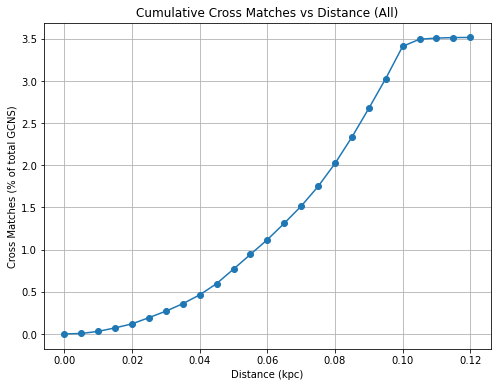

In [ ]:
# === 2) Identify the catalog flag columns ===
# Example: they are named like 'is_in_HIRES', 'is_in_NEID', etc.
catalog_flags = [col for col in catalog_summary.columns if col.startswith('is_in_')]

print("Catalog flag columns:", catalog_flags)

# === 3) Make a new column: does each row have any match? ===
catalog_summary['any_match'] = catalog_summary[catalog_flags].any(axis=1).astype(int)

# === 4) Define distance bins (in kpc) ===
bins = np.arange(0, catalog_summary['Dist50'].max() + 0.005, 0.005)

# === 5) For each bin, compute % of total GCNS with a match ===
percent_matches = []
for b in bins:
    within = catalog_summary[catalog_summary['Dist50'] <= b]
    if len(within) > 0:
        percent = within['any_match'].sum() / len(catalog_summary) * 100
    else:
        percent = 0
    percent_matches.append(percent)

# === 6) Plot ===
plt.figure(figsize=(8, 6))
plt.plot(bins, percent_matches, marker='o')
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of Cross Matches (% of total GCNS)')
plt.title('Cumulative Cross Matches vs Distance (All)')
plt.grid(True)
plt.show()

In [28]:
catalog_summary['Dist50'].max()

0.11931